<a href="https://colab.research.google.com/github/trietp1253201581/KaggleCompetition/blob/main/mnist_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer

## Download and explore the data

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [2]:
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
from zipfile import ZipFile
with ZipFile('digit-recognizer.zip') as f:
    f.extractall('digit-recognize-data')

In [4]:
import torch
import pandas as pd

In [5]:
data_dir = 'digit-recognize-data/'
raw_df = pd.read_csv(data_dir+'train.csv')
test_df = pd.read_csv(data_dir+'test.csv')
sub_df = pd.read_csv(data_dir+'sample_submission.csv')

In [6]:
input_cols = raw_df.columns.tolist()
input_cols.remove('label')
input_cols

['pixel0',
 'pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8',
 'pixel9',
 'pixel10',
 'pixel11',
 'pixel12',
 'pixel13',
 'pixel14',
 'pixel15',
 'pixel16',
 'pixel17',
 'pixel18',
 'pixel19',
 'pixel20',
 'pixel21',
 'pixel22',
 'pixel23',
 'pixel24',
 'pixel25',
 'pixel26',
 'pixel27',
 'pixel28',
 'pixel29',
 'pixel30',
 'pixel31',
 'pixel32',
 'pixel33',
 'pixel34',
 'pixel35',
 'pixel36',
 'pixel37',
 'pixel38',
 'pixel39',
 'pixel40',
 'pixel41',
 'pixel42',
 'pixel43',
 'pixel44',
 'pixel45',
 'pixel46',
 'pixel47',
 'pixel48',
 'pixel49',
 'pixel50',
 'pixel51',
 'pixel52',
 'pixel53',
 'pixel54',
 'pixel55',
 'pixel56',
 'pixel57',
 'pixel58',
 'pixel59',
 'pixel60',
 'pixel61',
 'pixel62',
 'pixel63',
 'pixel64',
 'pixel65',
 'pixel66',
 'pixel67',
 'pixel68',
 'pixel69',
 'pixel70',
 'pixel71',
 'pixel72',
 'pixel73',
 'pixel74',
 'pixel75',
 'pixel76',
 'pixel77',
 'pixel78',
 'pixel79',
 'pixel80',
 'pixel81',
 'pixel82',
 'pixel83',
 '

In [7]:
target_col = 'label'

In [8]:
for col in input_cols:
    raw_df[col] = raw_df[col]/255

In [9]:
input_tensor = torch.tensor(raw_df[input_cols].values, dtype=torch.float32)
target_tensor = torch.tensor(raw_df[target_col].values)

In [10]:
from torch.utils.data import TensorDataset, DataLoader

In [11]:
raw_ds = TensorDataset(input_tensor, target_tensor)
raw_ds[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

tensor(9)


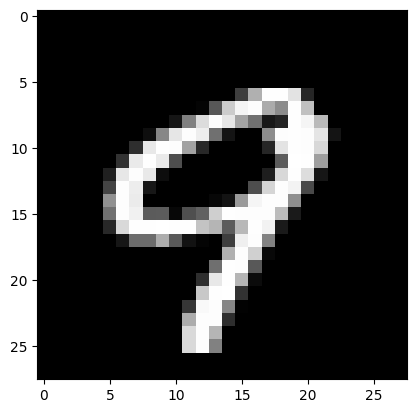

In [12]:
image_sample = raw_ds[100][0].reshape(28, 28)
import matplotlib.pyplot as plt
print(raw_ds[100][1])
plt.imshow(image_sample, cmap='gray')

In [13]:
random_seed = 42
torch.manual_seed(random_seed)

In [14]:
val_size = 8000
train_size = len(raw_ds) - val_size

In [15]:
train_ds, val_ds = torch.utils.data.random_split(raw_ds, [train_size, val_size])

In [16]:
batch_size = 128

In [17]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

## Model

In [18]:
def accurary(output, target):
    _, pred = torch.max(output, dim=1)
    return torch.tensor(torch.sum(pred==target).item()/len(target))

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class BaseModel(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.cross_entropy(out, targets)
        return loss

    def validation_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.cross_entropy(out, targets)
        acc = accurary(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [21]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)

In [22]:
get_default_device()

device(type='cuda')

In [23]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), get_default_device())
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [24]:
test_df[input_cols] = test_df[input_cols]/255

In [27]:
test_ds = TensorDataset(torch.tensor(test_df[input_cols].values, dtype=torch.float32))

## CNN Model

In [28]:
input_tensor = input_tensor.reshape(-1, 1, 28, 28)

raw_ds = TensorDataset(input_tensor, target_tensor)
raw_ds[0][0].shape

torch.Size([1, 28, 28])

In [29]:
import torchvision.transforms as T
input_tensor = T.Resize((32, 32))(input_tensor)

In [30]:
raw_ds = TensorDataset(input_tensor, target_tensor)
raw_ds[0][0].shape

torch.Size([1, 32, 32])

tensor(9)


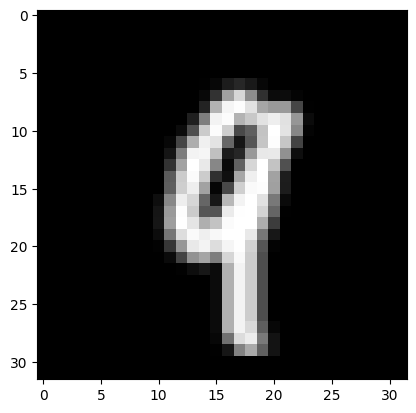

In [31]:
image_sample = raw_ds[501][0].permute(1, 2, 0)
import matplotlib.pyplot as plt
print(raw_ds[501][1])
plt.imshow(image_sample, cmap='gray')

In [32]:
train_ds, val_ds = torch.utils.data.random_split(raw_ds, [train_size, val_size])

In [33]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [34]:
train_dl = DeviceDataLoader(train_dl, get_default_device())
val_dl = DeviceDataLoader(val_dl, get_default_device())

In [46]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [47]:
class CNNModel(BaseModel):
    def __init__(self):
        super().__init__()

        self.prep = conv_block(1, 64)
        self.layer1 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.layer2 = conv_block(128, 256, pool=True)
        self.layer3 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, 10))

    def forward(self, xb):
        out = self.prep(xb)
        out = self.layer1(out)
        out = self.res1(out) + out
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [48]:
CNNModel()

CNNModel(
  (prep): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=T

In [49]:
cnn_model = to_device(CNNModel(), get_default_device())

In [38]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def fit_cnn(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training
        model.train()
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation
        result = evaluate(model, val_dl)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [50]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

In [51]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [52]:
def fit_cnn(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.SGD,
            weight_decay=0,grad_clip=None):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs,
                                                steps_per_epoch=len(train_dl))
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            sched.step()
        # Validation
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [53]:
history = [evaluate(cnn_model, val_dl)]
history

[{'val_loss': 2.3038201332092285, 'val_acc': 0.0946044921875}]

In [54]:
history += fit_cnn(7, 0.01, cnn_model, train_dl, val_dl, opt_func=torch.optim.Adam,
                   weight_decay=1e-4, grad_clip=0.1)

Epoch [0], val_loss: 0.4080, val_acc: 0.9105
Epoch [1], val_loss: 0.1767, val_acc: 0.9581
Epoch [2], val_loss: 0.5582, val_acc: 0.9012
Epoch [3], val_loss: 0.0477, val_acc: 0.9865
Epoch [4], val_loss: 0.0420, val_acc: 0.9893
Epoch [5], val_loss: 0.0260, val_acc: 0.9934
Epoch [6], val_loss: 0.0249, val_acc: 0.9945


In [55]:
for t in cnn_model.parameters():
    print(t.shape)

torch.Size([64, 1, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [56]:
test_input_tensors = torch.tensor(test_df[input_cols].values, dtype=torch.float32)
test_input_tensors = test_input_tensors.reshape(-1, 1, 28, 28)
test_input_tensors = T.Resize((32, 32))(test_input_tensors)
test_input_tensors = test_input_tensors.reshape(-1, 1, 32, 32)
test_ds = TensorDataset(test_input_tensors)

2


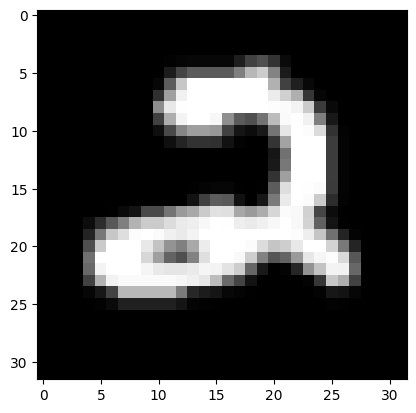

In [58]:
image_sample = test_ds[0][0].permute(1, 2, 0)
print(predict_image(test_ds[0][0], cnn_model))
plt.imshow(image_sample, cmap='gray')

In [59]:
for i in range(len(test_ds)):
    sub_df.loc[i, 'Label'] = predict_image(test_ds[i][0], cnn_model)
sub_df.to_csv('submission.csv', index=False)

9


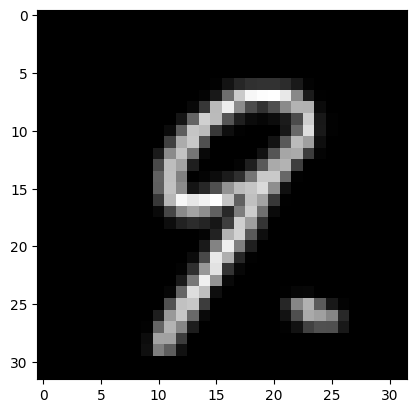

In [62]:
image_sample = test_ds[2][0].permute(1, 2, 0)
print(predict_image(test_ds[2][0], cnn_model))
plt.imshow(image_sample, cmap='gray')